In [ ]:
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cuda = torch.cuda.is_available()

## Moving to neural networks

Now that we've seen how adversarial examples work in the context of linear models, let's move to the setting we really care about: the possibility of adversarial examples in deep neural networks.

First, let us define formally a neural network. Let us define $h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ to be an $d$-layer network, given by the following equations
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $z_i$ denote the activations at layer $i$; $f_i$ denotes the activation function for layer $i$, which we will often take to be e.g. the ReLU operator $f_i(z) = \max\{0,z\}$ for layers $i=1,\ldots,d-1$ and the linear operator $f_i(z) = z$ for layer $d$ (remember, the last layer outputs are the class logits, and the loss function "builds in" the softmax operator, so we don't explicitly put the softmax into the network); and the parameters of the network are given by $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (in the above, $W_i$ is most obviously interpreted a matrix, but it could really be any linear operator including convolutions).  We won't worry for now about explicitly defining the size of all the intermediate layers, but we assume that they are specified such that the final function $h_\theta$ takes inputs in $\mathbb{R}^n$ and outputs vectors in $\mathbb{R}^k$.  The loss function for multiclass case, namely the Cross Entropy loss, is as follows:
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

## Crafting an attack

Unlike it the linear case, it is _not_ easy to solve, the maximization problem over our perturbation. This is because the cost surface for neural networks (here considering it over the _input_ space, not parameter space) is not convex, and is especially prone to local optima.  We can see this even in the simple example above, where there are local optimal when either trying to maximize or minimize the function above, and the initial gradient at a given point may or may not point in the direction of the actual maxima.

So how _do_ we go about (approximately) solving the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y)
\end{equation}
in the case of $h_\theta$ being a neural network?

The most common strategy to approximate the pertubation is to find a _lower bound_ on the optimization objective.  Because (by definition) _any_ feasible $\delta$ will give us a lower bound, this is equivalent to just "trying to empirically solve the optimization problem", i.e., "find an adversarial example."  
This is by far the most common strategy for solving the inner maximization motivated largely by the fact that for neural networks in general, problems of local optima don't seem as bad as initially may be thought.

## Lower bounding the inner maximization (i.e., adversarial attacks)

Let's start by considering perhaps the simplest way of solving the optimization problem we care about, the task of maximizing
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
In fact we already saw one example for how to do this in our introductory lecture, but the basic idea here is quite simple: using backpropagation, we can compute the gradient of the loss function with respect to the perturbation $\delta$ itself, so let's just perform gradient descent on $\delta$ to maximize our objective.  However, we also need to ensure that $\delta$ stays within the norm bound $\epsilon$, so after each step, we can project back into this space.



### The Fast Gradient Sign Method (FGSM)

Let's consider in a bit more detail how we might do the attack we mentioned above.  For some given example $x$, we know that we are going to adjust $\delta$ in the direction of it's gradient, i.e., we will first compute the gradient
\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}
using simple backpropagation; note that if we're evaluating this gradient at $\delta=0$ (as we would at the first timestep), then this is also just equal to $\nabla_x \ell(h_\theta(x),y)$, but we'll express the gradients in terms of $\delta$ to be consistent with how we do things going forward.

In order to maximize loss, we want to adjust delta in the direction of this gradient, i.e., take a step
\begin{equation}
\delta := \delta + \alpha g
\end{equation}
for some step size $\alpha$ and then project back into the norm ball defined by $\|\delta\| \leq \epsilon$.  But how big a step do we take?  For concreteness, let's consider the particular case of the $\ell_\infty$ norm $\|\delta\|_\infty \leq \epsilon$, where, as we mentioned before, projecting onto this norm ball simply involves clipping values of $\delta$ to lie within the range $[-\epsilon, \epsilon]$.  If our initial $\delta$ is zero, this gives the update
\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}
Now, how big of a step size should we take?  If we want to make increase the loss as much as possible, it makes sense to take as large a step as possible, i.e., take $\alpha$ to be very large (of course knowing that we won't take _that_ big a step, since we're projecting back into the $\ell_\infty$ ball afterwards).  It is not hard to see that for $\alpha$ large enough, the relative sizes of the entries of $g$ won't matter: we will simply take $\delta_i$ to be either $+\epsilon$ or $-\epsilon$ depending upon the sign of $g_i$.  In other words, for large $\alpha$, this update becomes
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

This is know as the Fast Gradient Sign Method (FGSM) [1], and it was one of the first methods for constructing adversarial examples proposed by the deep learning community.

[1] Explaining and Harnessing Adversarial Examples

### Exercice 2
1. Define a neural network with 3 fully connected layers
2. Define a neural network with 2 convolutional layers and a last fully connected layer
2. Train the network on the full CIFAR-10 Dataset
3. Code the FGSM attack
4. Evaluate your model against FGSM
5. Plot some images with and without the adversarial perturbation
6. Make an analysis of FGSM attack and compare it with the attack from the first notebook

In [ ]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10("./docs", train=train, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

batch_size = 144
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)

Files already downloaded and verified
Files already downloaded and verified


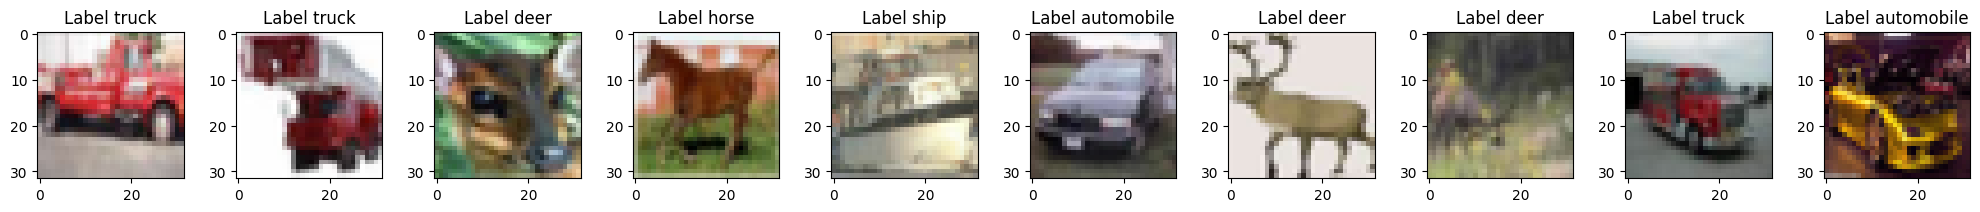

In [ ]:
plt.figure(figsize=(20, 2))
imgs, labels = next(iter(train_loader))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(imgs[k].reshape(3, 32, 32).numpy().transpose(1, 2, 0), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Label {cifar10_classes[int(labels[k].item())]}')
plt.tight_layout()

In [ ]:
def train_model(model, criterion, optimizer, loader):
  """Function to train the model"""
  train_loss = 0.
  model.train()
  epochs = 10

  #ajouter nombre d'epochs
  for e in range(epochs):
    for batch_idx, (imgs, labels) in enumerate(train_loader):
      if cuda:
       imgs, labels = imgs.cuda(), labels.cuda()
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(imgs)
      # calculate the batch loss
      loss = criterion(output, labels)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*imgs.size(0)


  return train_loss / len(train_loader.dataset)



In [ ]:
# convolutional model with 2 convolution, 2 max pooling layer, 3 fully connected layer
# the model should be: 2x (conv -> max pooling -> relu) -> 2x (fc -> relu) -> fc
# Use a kernel size 3 and a padding of 1 to keep the channels spatial dimensions

class ConvModel(torch.nn.Module):

  def __init__(self):
    super(ConvModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 3, padding=1) # 3 input channels, 6 output channels (doit être sup a input), 3x3 kernel
    self.pool = nn.MaxPool2d(2) # 2x2 kernel
    self.conv2 = nn.Conv2d(6, 16, 3, padding=1) # 6 input channels, 16 output channels, 3x3 kernel
    self.fc1 = nn.Linear(16 * 8 * 8, 120) # 16x8x8 input features, 120 output features
    self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
    self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    #print(x.size())
    x = x.view(-1, 16 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x



In [ ]:
model = ConvModel()
x_test = torch.rand(1, 3, 32, 32)
#model(x_test)
if cuda:
  model = model.cuda()
print(list(x.size() for x in model.parameters()))


[torch.Size([6, 3, 3, 3]), torch.Size([6]), torch.Size([16, 6, 3, 3]), torch.Size([16]), torch.Size([120, 1024]), torch.Size([120]), torch.Size([84, 120]), torch.Size([84]), torch.Size([10, 84]), torch.Size([10])]


In [ ]:
# define your loss function
criterion = nn.CrossEntropyLoss()

# define your optimizer
opt = optim.SGD(model.parameters(), lr=1e-2)

train_model(model, criterion, opt, train_loader)

11.50700423057556

In [ ]:
def eval_model(model, loader, attack=None):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
    if cuda:
      imgs, labels = imgs.cuda(), labels.cuda()
    if attack is None:
      outputs = model(imgs)
    else:
      delta = attack.compute(imgs, labels)
      adv = imgs + delta
      outputs = model(adv)
    _, predicted = torch.max(outputs.data, 1)
    accuracy += predicted.eq(labels.data).cpu().sum().numpy()
    n_inputs += imgs.shape[0]
  accuracy /= n_inputs
  print('accuracy on testset: {:.4f}'.format(accuracy))

eval_model(model, test_loader)

accuracy on testset: 0.1591


In [ ]:
class FastGradientSignMethod:

  def __init__(self, model, eps):
    super().__init__()
    self.model = model
    self.eps = eps
    self.loss = nn.CrossEntropyLoss()

  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""
    x.requires_grad = True
    y_pred = self.model(x)
    loss = self.loss(y_pred, y)
    loss.backward()
    grad = x.grad.data
    grad = grad.sign()
    return self.eps * grad
    #delta = torch.zeros_like(x, requires_grad=True)
    # code here ...
    # Use variable.grad.detach() to retreive the gradient with respect to a loss
eps = 0.007 # define eps here

fgsm = FastGradientSignMethod(model,eps)

eval_model(model, test_loader, fgsm)

accuracy on testset: 0.0910


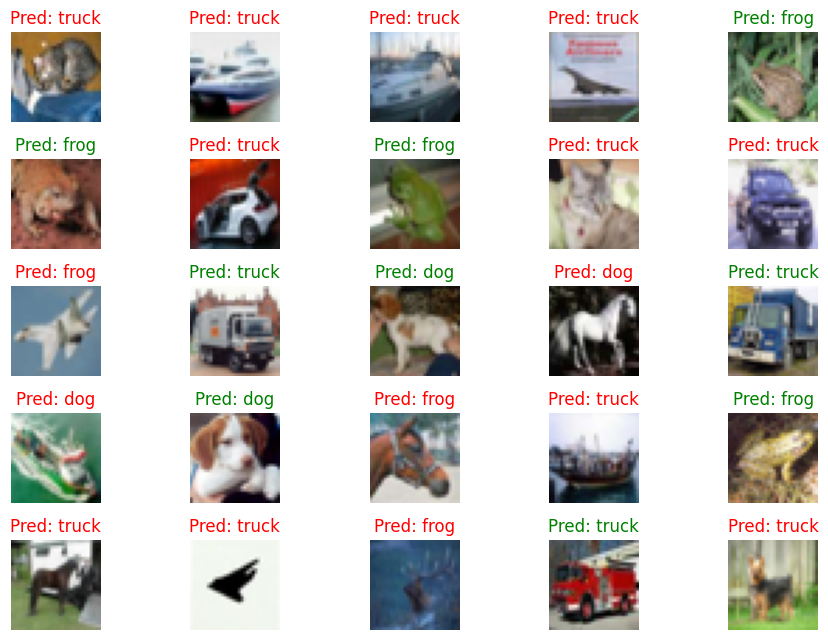

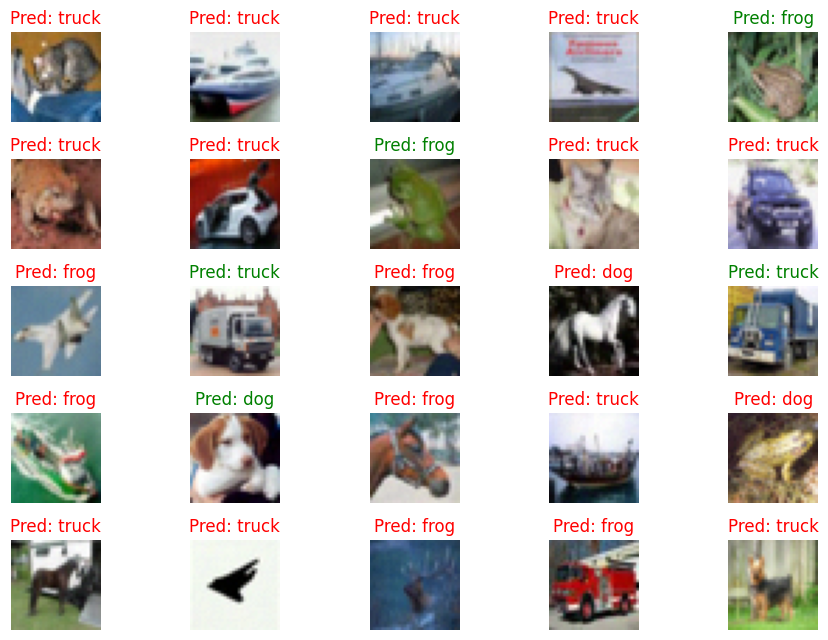

In [ ]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().detach().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N*2, M*1.3))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title("Pred: {}".format(cifar10_classes[int(yp[i*N+j].max(dim=0)[1])]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()

for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# plot natural images
output = model(imgs)
plot_images(imgs, labels, output)

# plot adversarial images
delta = fgsm.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs + delta, labels, output)

### Projected gradient descent

This discussion immediately brings us to the next approach we would want to consider for maximizing the optimization problem, just doing projected gradient descent (i.e., the above procedure, but iterating it and with a smaller step size). [Note: technically speaking, this is gradient _ascent_ since we are maximizing a function rather than minimization, but it's common to just refer to the process as gradient descent.]. This was also called the "basic iterative procedure" in it's first appearance within the adversarial attacks literature [1], but essentially it is just the obvious choice for how we might maximize the inner objective a bit more carefully than with FGSM. The basic PGD algorithm simply iterates the updates:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}
where $\mathcal{P}$ denotes the projection onto the ball of interest (for example, clipping in the case of the $\ell_\infty$ norm).  Of course, with PGD we now have more choices we need to make when specifying the attack, such as the actual stepsize itself, and the number of iterations (we'll discuss some rules of thumb shortly once we present a slightly modified version of the above iteration).  We can implement this attack in the following manner, where we're here going to implement the gradient descent procedure rather than rely on one of PyTorch's optimizers, as we want to see what's going on a bit more explicitly (PyTorch's SGD also includes terms like momentum, which actually usually are able to optimize the inner term _better_, but we want to have as little black-box procedures here as possible).

[1] Adversarial Machine Learning At Scale

Build the $\ell_\infty$-PGD attack:

In [ ]:
class ProjectedGradientDescent:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha #le pas
    self.num_iter = num_iter #nb iteration
    self.loss = nn.CrossEntropyLoss()



  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(self.num_iter):
      y_pred = self.model(x+delta)
      loss = self.loss(y_pred, y)
      loss.backward()
      grad = delta.grad
      delta.data = delta.data + self.alpha * grad.detach().sign()
      delta.data = torch.clamp(delta, -self.eps, self.eps) #projection sur le cercle
      #delta.grad.zero_()
    return delta.detach()

alpha = 1e-2

pgd = ProjectedGradientDescent(model, eps, alpha, 5)
eval_model(model, test_loader, pgd)

accuracy on testset: 0.0844


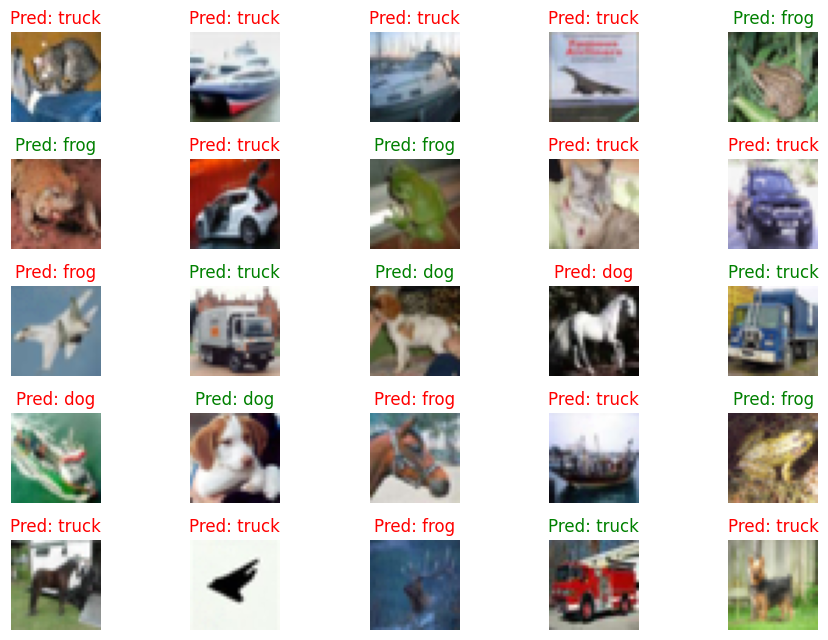

In [ ]:
pgd = ProjectedGradientDescent(model, eps, delta, 100)
delta = pgd.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs+delta, labels, output)

**BONUS**: Try to implement the $\ell_2$-PGD attack.

In [ ]:
class ProjectedGradientDescentl2:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha #le pas
    self.num_iter = num_iter #nb iteration
    self.loss = nn.CrossEntropyLoss()
    self.norm = nn.functional.normalize

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(self.num_iter):
      y_pred = self.model(x+delta)
      loss = self.loss(y_pred, y)
      loss.backward()
      grad = delta.grad
      delta.data = delta.data + self.alpha * grad.detach().sign()
      mask = (self.norm(delta.data)<eps)*1
      delta.data = mask*delta.data + (1-mask)*delta.data*self.eps/self.norm(delta.data)
      #delta.grad.zero_()
    return delta.detach()

num_iter = 5
pgdl2 = ProjectedGradientDescentl2(model, eps, alpha, num_iter)
eval_model(model, test_loader, pgdl2)

accuracy on testset: 0.1000


### Test you attacks on real world images

In [ ]:
!mkdir docs
!wget https://www.lamsade.dauphine.fr/~averine/ProjetIA/pig.jpg -P docs
!wget https://www.lamsade.dauphine.fr/~averine/ProjetIA/imagenet_class_index.json -P docs

mkdir: cannot create directory ‘docs’: File exists
--2024-09-16 16:33:12--  https://www.lamsade.dauphine.fr/~averine/ProjetIA/pig.jpg
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56267 (55K) [image/jpeg]
Saving to: ‘docs/pig.jpg’

pig.jpg             100%[===================>]  54.95K   201KB/s    in 0.3s    

2024-09-16 16:33:13 (201 KB/s) - ‘docs/pig.jpg’ saved [56267/56267]

--2024-09-16 16:33:13--  https://www.lamsade.dauphine.fr/~averine/ProjetIA/imagenet_class_index.json
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘docs/imagenet_class_index.json’

imagenet_class_inde 100%[====

Let's use the (pre-trained) ResNet50 model within PyTorch to classify this picture of a pig.


The normal strategy for image classification in PyTorch is to first transform the image (to approximately zero-mean, unit variance) using the `torchvision.transforms` module.  However, because we'd like to make perturbations in the original (unnormalized) image space, we'll take a slightly different approach and actually build the transformations at PyTorch layers, so that we can directly feed the image in.  First, let's just load the image and resize the 224x224, which is the default size that most ImageNet images (and hence the pre-trained classifiers) take as input.

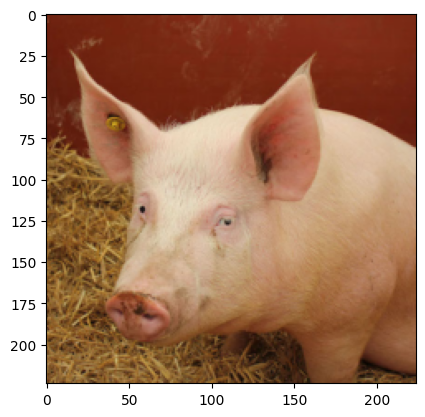

In [ ]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("docs/pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.show()

In [ ]:
from torchvision.models import resnet50

class NormModel(nn.Module):
  def __init__(self, model):
      super(NormModel, self).__init__()
      self.model = model
      self.norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  def forward(self, x):
      return self.model(self.norm(x))
# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py


# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = NormModel(resnet50(pretrained=True))
model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# form predictions
pred = model(pig_tensor)
print(torch.argmax(pred))
with open("docs/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

tensor(341)
hog


torch.Size([1, 3, 224, 224])
tensor([341])


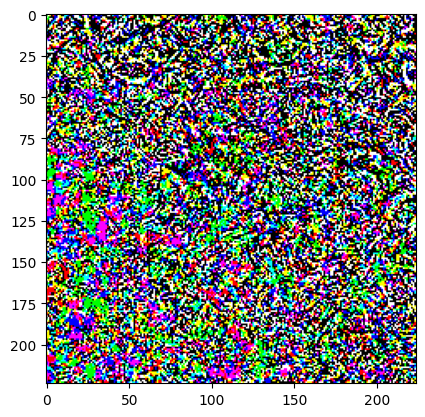

In [ ]:
# attack the pig image and plot the perturbation

class ProjectedGradientDescentl2:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha #le pas
    self.num_iter = num_iter #nb iteration
    self.loss = nn.CrossEntropyLoss()
    self.norm = nn.functional.normalize

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(self.num_iter):
      y_pred = self.model(x+delta)
      loss = self.loss(y_pred, y)
      loss.backward()
      grad = delta.grad
      delta.data = delta.data + self.alpha * grad.detach().sign()
      mask = (self.norm(delta.data)<eps)*1
      delta.data = mask*delta.data + (1-mask)*delta.data*self.eps/(self.norm(delta.data) + 1E-6)
      #delta.grad.zero_()
    return delta.detach()

num_iter = 5
alpha = 1e-2
eps = 0.01
pgdl2 = ProjectedGradientDescentl2(model, eps, alpha, num_iter)

model = model.cuda()
#eval_model(model, test_loader, pgdl2)

print(pig_tensor.shape)
print(pred.max(dim=1)[1])

#plot the perturbation
delta = pgdl2.compute(pig_tensor.cuda(), pred.max(dim=1)[1].cuda())

plt.imshow(1e10 * delta[0].cpu().numpy().transpose(1,2,0))
plt.show()


In [ ]:
pred = model(pig_tensor.cuda() + delta.cuda())
print(torch.argmax(pred))
print(imagenet_classes[pred.max(dim=1)[1].item()])



tensor(470, device='cuda:0')
candle


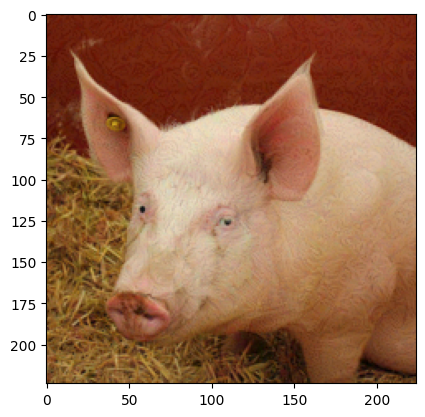

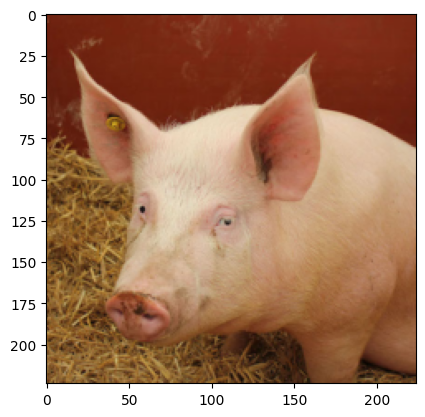

In [ ]:
plt.imshow((pig_tensor[0].cpu()+delta[0].cpu()).numpy().transpose(1,2,0))
plt.show()
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.show()

torch.Size([1, 3, 224, 224])
tensor([470], device='cuda:0')


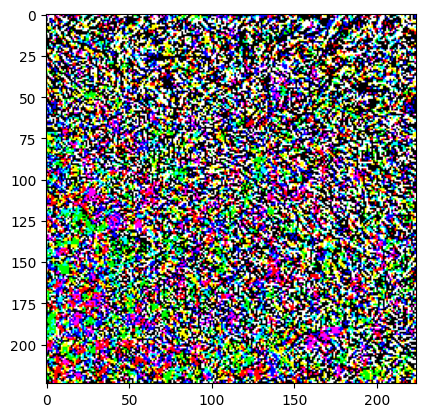

In [94]:
# attack the pig image and plot the perturbation

class ProjectedGradientDescent:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha #le pas
    self.num_iter = num_iter #nb iteration
    self.loss = nn.CrossEntropyLoss()
    self.norm = nn.functional.normalize

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(self.num_iter):
      y_pred = self.model(x+delta)
      loss = self.loss(y_pred, y)
      loss.backward()
      grad = delta.grad
      delta.data = delta.data + self.alpha * grad.detach().sign()
      mask = (self.norm(delta.data)<eps)*1
      delta.data = mask*delta.data + (1-mask)*delta.data*self.eps/(self.norm(delta.data) + 1E-6)
      #delta.grad.zero_()
    return delta.detach()

num_iter = 5
alpha = 1e-2
eps = 0.01
pgd = ProjectedGradientDescent(model, eps, alpha, num_iter)

model = model.cuda()
#eval_model(model, test_loader, pgdl2)

print(pig_tensor.shape)
print(pred.max(dim=1)[1])

#plot the perturbation
delta = pgd.compute(pig_tensor.cuda(), pred.max(dim=1)[1].cuda())

plt.imshow(1e10 * delta[0].cpu().numpy().transpose(1,2,0))
plt.show()


In [95]:
pred = model(pig_tensor.cuda() + delta.cuda())
print(torch.argmax(pred))
print(imagenet_classes[pred.max(dim=1)[1].item()])


tensor(341, device='cuda:0')
hog


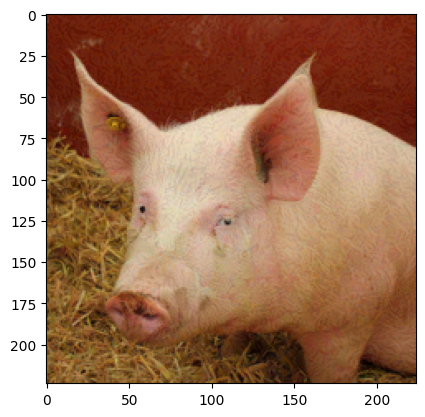

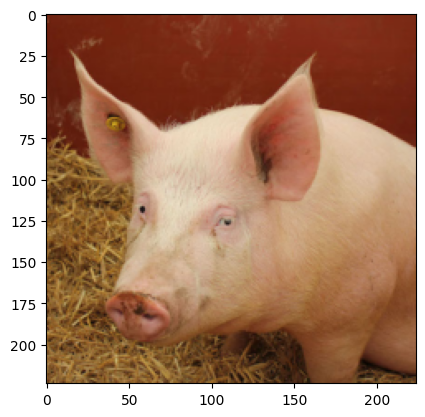

In [96]:
plt.imshow((pig_tensor[0].cpu()+delta[0].cpu()).numpy().transpose(1,2,0))
plt.show()
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.show()